In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
import math

In [2]:
#initial data
suits = ["c","s","d","h"]
vecRev = np.array([ 0.25,  1.5,  3,  5,  9, 15 , 20, 27, 38, 50])
probs = np.array([0.501177,0.422569,0.047539,0.021128,0.003925,0.001965,0.001441,0.0002401,0.0000139,0.00000154])

In [3]:
##stats
cntRate = [0 for i in range(10)]
revenue = []
winrate = []
vecVals = []
exp = []
AllBets = []

In [4]:
#generate a standard deck of 52 cards and shuffle it
def CreateDeck():
    deck = []
    for i in range(2,15):
        for s in suits:
            deck.append([i,s])
    random.shuffle(deck)
    return deck

In [5]:
#retrive 5 cards from the top of the deck and return a sorted hand
def GetHand(deck):
    hand = []
    for i in range(5):
        hand.append(deck[i])
    return pd.DataFrame(hand).sort_values(0, ascending=False).to_numpy()

In [6]:
#returns the rate of hand
def getRate(hand):
    grpby = np.array(sorted((hand.groupby([0]).count()[1]).to_numpy(), reverse = True))
    if(np.array_equal(grpby,np.array([1,1,1,1,1]))):
        straight = checkStraight(hand[0].to_numpy())
        flush = checkFlush(hand)
        if(straight and flush):
            if(hand[0][0] == 14):
                return 9
            else:
                return 8
        elif (flush):
            return 5
        elif(straight):
            return 4
        else:
            return 0
    elif(np.array_equal(grpby,np.array([4,1]))):
        return 7
    elif(np.array_equal(grpby,np.array([3,2]))):
        return 6
    elif(np.array_equal(grpby,np.array([3,1,1]))):
        return 3
    elif(np.array_equal(grpby,np.array([2,2,1]))):
        return 2
    else:
        return 1

In [7]:
#checks if all of the cards suits are the same
def checkFlush(hand):
    grpby = np.array(sorted(hand.groupby([1]).count()[0].to_numpy(), reverse = True))
    if(grpby[0] == 5):
        return True
    else:
        return False
    

In [8]:
#checks if there is a sequence in a pre sorted hand
def checkStraight(hand):
    if(hand[1] == 5 and hand[0] == 14):
        ##because of Pigeonhole principle if the hishest card is A and the second highest is 5 the others needs to be 4,3,2
        return True
    for i in range(len(hand)-1):
        if(hand[i] != hand[i+1]+1):
            return False
    return True

In [9]:
#checks if 4 of the cards in the hand got the same suit
def checkPotentialFlush(hand):
    grpby = np.array(sorted(hand.groupby([1]).count()[0].to_numpy(), reverse = True))
    if(grpby[0] == 4):
        return 1
    else:
        return 0

In [10]:
#checks whether or not, replacing one card in the hand can form a straigth and returns the number of potential cards
def checkPotentialStraight(hand):
    if(hand[0] == 14 and hand[2] < 6):
        return [1,1]
    if(hand[0] == 14 and hand[3] == 11):
        return [1,4]
    if(hand[0] - hand[3] == 4):
        return [1,4]
    if(hand[1]-hand[4] == 4):
        return [1,0]
    if(hand[0] - hand[3] == 3):
        return [2,4]
    if(hand[1]-hand[4] == 3):
        return [2,0]
    return [0,-1]

In [11]:
#the function will get an int representing the bid of the player and will instantiate a slot game. 
## first, it will create a deck and shuffle it, next it will pick a random number to check if its gonna be a regular game 
## or a "supershuffle" one. then it will pick a hand and calculate its rate for the prize.
### if the rate is zero and there is a potential of switching one card to gain flush/straight the function will again pick a
### random number, if its big enought the function will replace a card wishing to win a flush or a straight.
#### at the end the function will return a tuple of how much money the player won and how much he paid.
def Bet(bid,vecRev):
    deck = CreateDeck()
    rnd = random.randint(0,50)
    if(rnd<3):
        return superShuff(deck,rnd,bid)
    hand = GetHand(deck)
    df = pd.DataFrame(hand)
    #print(df)
    rate = getRate(df)
    cntRate[rate] += 1
    if(rate > 0):
        c = calcRev(vecRev,getImportantVal(df)[0],rate,bid) - bid
        #print("--rev of "+ str(c/bid) + " the bid--")
        return [c,bid]
    potS = checkPotentialStraight(df[0].to_numpy())
    potF =checkPotentialFlush(df)
    pot = potS[0] + potF
    if(pot > 0):
        if(random.randint(0, 100)*pot > 75):
            hand[potS[1]] = deck[5]
            #print("new hand")
            #print(hand)
            rate = getRate( pd.DataFrame(hand))
            if(rate > 0):
                cntRate[rate] += 1
                cntRate[0] -= 1
                c = calcRev(vecRev,getImportantVal(df)[0],rate,bid) - (3*bid/2)
                
                #print("--rev of "+ str(c/bid) + " the bid--")
                return [c,3*bid/2]
            bid = 3*bid/2
    return [-bid,bid]
            
        

In [12]:
#the function will generate 100 to 300 slot games and return a tuple representing the revenue of the most profitable one.
def superShuff(deck,rnd,bid):
    #print("######SuperSuff!!!!#####")
    hand = GetHand(deck)
    dataframe = pd.DataFrame(hand)
    rate = getRate(dataframe)
    dataframe = getImportantVal(dataframe)
    #print(dataframe)
    for i in range(int(300/(rnd+1))):
        deck = CreateDeck()
        h = GetHand(deck)
        df = pd.DataFrame(h)
        r = getRate(df)
        df = getImportantVal(df)
        if(rate < r or (rate == r and df[0] > dataframe[0])):
            rate = r
            hand = h
            #print(h)
    #print(h)    
    #print("#####EndSuperShuff")
    cntRate[rate] += 1
    if(rate > 0):
        c = calcRev(vecRev,df[0],rate,bid) - bid
        print("--rev of "+ str(c/bid) + " the bid--")
        return [c,bid]
    return [-bid,bid]
            

In [13]:
#returns the two most importand card numbers in a hand.
def getImportantVal(df):
    a = []
    df = df.groupby([0]).count().sort_values(1, ascending=False)
    for row in df.head(2).iterrows():
        a.append(row[0])
    return a
    

In [14]:
#calculate the revenue from a hand using the rate and the most valubale card in the hand.
def calcRev(vecRev,highcard,rate,bid):
    Rbound = vecRev[rate]
    Lbound = vecRev[rate - 1]
    c = (Rbound - Lbound) / 14
    h = bid * ((c * highcard)+Lbound)
    return h   

In [15]:
#the function will get a vector of the revenue ratios and will return the expected value of revenue from picking a random hand.
def calcExpectedValue(vecRev):
    sum = 0
    k = [0,13,12,13,10,13,12,13,9,1]

    for i in range(1,10):
        for j in range(1,k[i]):
            sum += (calcRev(vecRev,j,i,1)*probs[i]/k[i])
        if(i == 1):
            print(sum)
    return sum
        

In [16]:
#the function will get hypothesis Null(H0) we want to check, the number of tests we want to take and alpha.
#the return value is the rejection area of the test
##H0: μ0 = target
##HA: μA != target
def findCAlpha(target,n,Alpha):
    return [target - norm.ppf(1-Alpha)*math.sqrt(target*(1-target)/n),target + norm.ppf(1-Alpha)*math.sqrt(target*(1-target)/n)]

In [17]:
#this function will get all of the parameters for the test we want to check.
#will generate n games of 15 random bets, and check the revenue we got from each game
#then, the function will use some sort of binary search in order to find and return a vector of reveanue ratios in order that 
#are not in the rejection area.
def vecRevBinarySearch(vecRev,rng,Alpha,n,target):
    binp = -1
    count = 0
    print(vecRev)
    Ca = findCAlpha(target,n,Alpha)
    print(Ca)
    vecRev = vecRevBinarySearchRec(Ca,binp,vecRev,rng,Alpha,n,target)
    return vecRev


In [18]:
def vecRevBinarySearchRec(Ca,binp,vecRev,rng,Alpha,n,target):
    count =0
    revenue = []
    doublerev = []
    regrev = []
    print(vecRev)
    print("@#@#@#@$#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@# New Game @#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@@#")
    for i in range(n):
        print("#-#-#-#New Round #-#-#")
        rev = 0
        bid = 100
        spend = 0
        double = random.randint(0,3)%2
        startbid = 100
        for j in range(5):
            b = Bet(bid,vecRev)
            rev += b[0]
            spend += b[1]
            AllBets.append(b[0])
            if(b[0] == 0 and double == 1):
                bid *= 2
            else:
                bid = startbid
            #print(rev)
        revenue.append(rev)
        if(double == 1):
            doublerev.append(rev)
        else:
            regrev.append(rev)
        if(rev > 0):
            print("we won: "+str(rev))
            count+=1
        else:
            print("we lost: "+str(-rev))
    print("win rate: "+str(count/n))
    print("max won: "+str(np.array(revenue).max()))
    print("max lost: "+str(np.array(revenue).min()))
    print("mean revenue: "+str(np.array(revenue).mean()))
    print("mean double revenue: "+str(np.array(doublerev).mean()))
    print("mean reg revenue: "+str(np.array(regrev).mean()))
    print("total gain: "+str(np.array(revenue).sum()))
    print("Expected Value of Revenue: "+str(calcExpectedValue(vecRev)))
    print("Empirical Revenue: "+str(np.array(AllBets).mean()))
    winrate.append((count/n))
    vecVals.append(vecRev)
    exp.append(calcExpectedValue(vecRev))
    pd.DataFrame(revenue).plot(kind='density')
    if((count/n) > Ca[1]):
        if(binp == 0):
            rng = (rng - 1)/2 + 1
        vecRev = vecRev / rng
        binp = 1
        print(vecRev)
        vecRev = vecRevBinarySearchRec(Ca,binp,vecRev,rng,Alpha,n,target)
    elif(count/n < Ca[0]):
        if(binp == 1):
            rng = (rng - 1)/2 + 1
        vecRev = vecRev * rng
        binp = 0
        print(vecRev)
        vecRev = vecRevBinarySearchRec(Ca,binp,vecRev,rng,Alpha,n,target)
    print(vecRev)
    return vecRev

    

[ 0.25  1.5   3.    5.    9.   15.   20.   27.   38.   50.  ]
[0.4390660802316469, 0.5009339197683531]
[ 0.25  1.5   3.    5.    9.   15.   20.   27.   38.   50.  ]
@#@#@#@$#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@# New Game @#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@#@@#
#-#-#-#New Round #-#-#
we lost: 298.2142857142857
#-#-#-#New Round #-#-#
we lost: 176.78571428571428
#-#-#-#New Round #-#-#
--rev of 3.1428571428571423 the bid--
we won: 596.4285714285713
#-#-#-#New Round #-#-#
we lost: 174.99999999999997
#-#-#-#New Round #-#-#
we won: 5.357142857142833
#-#-#-#New Round #-#-#
we lost: 307.1428571428571
#-#-#-#New Round #-#-#
we lost: 169.64285714285717
#-#-#-#New Round #-#-#
we lost: 71.42857142857142
#-#-#-#New Round #-#-#
--rev of 5.714285714285714 the bid--
we won: 503.5714285714286
#-#-#-#New Round #-#-#
--rev of 15.785714285714285 the bid--
we won: 1317.8571428571427
#-#-#-#New Round #-#-#
--rev of 6.571428571428571 the bid--
we won: 600.0
#-#-#-#New Round #-#-#
--rev of 15.7857142857

--rev of 5.428571428571429 the bid--
we won: 135.71428571428575
#-#-#-#New Round #-#-#
we won: 78.57142857142858
#-#-#-#New Round #-#-#
we lost: 123.21428571428571
#-#-#-#New Round #-#-#
we lost: 178.57142857142858
#-#-#-#New Round #-#-#
--rev of 5.714285714285714 the bid--
we won: 771.4285714285714
#-#-#-#New Round #-#-#
we lost: 333.92857142857144
#-#-#-#New Round #-#-#
we lost: 358.92857142857144
#-#-#-#New Round #-#-#
we lost: 123.21428571428572
#-#-#-#New Round #-#-#
we lost: 376.7857142857143
#-#-#-#New Round #-#-#
we lost: 85.7142857142857
#-#-#-#New Round #-#-#
we lost: 282.14285714285717
#-#-#-#New Round #-#-#
--rev of 4.857142857142857 the bid--
we won: 189.28571428571422
#-#-#-#New Round #-#-#
--rev of 14.714285714285714 the bid--
we won: 1414.2857142857142
#-#-#-#New Round #-#-#
we lost: 208.92857142857142
#-#-#-#New Round #-#-#
--rev of 2.7142857142857144 the bid--
we won: 46.428571428571445
#-#-#-#New Round #-#-#
we lost: 75.00000000000001
#-#-#-#New Round #-#-#
we lost: 

--rev of 17.92857142857143 the bid--
we won: 1594.6428571428576
#-#-#-#New Round #-#-#
--rev of 12.714285714285715 the bid--
we won: 976.7857142857144
#-#-#-#New Round #-#-#
we lost: 26.785714285714292
#-#-#-#New Round #-#-#
we won: 1782.1428571428569
#-#-#-#New Round #-#-#
--rev of 1.6785714285714288 the bid--
we won: 57.14285714285717
#-#-#-#New Round #-#-#
--rev of 1.1428571428571428 the bid--
we won: 64.28571428571428
#-#-#-#New Round #-#-#
we lost: 333.92857142857144
#-#-#-#New Round #-#-#
we lost: 260.7142857142857
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we lost: 219.64285714285714
#-#-#-#New Round #-#-#
we lost: 358.92857142857144
#-#-#-#New Round #-#-#
we lost: 367.8571428571429
#-#-#-#New Round #-#-#
we lost: 394.6428571428571
#-#-#-#New Round #-#-#
we lost: 253.57142857142856
#-#-#-#New Round #-#-#
we lost: 317.8571428571429
#-#-#-#New Round #-#-#
we lost: 255.35714285714286
#-#-#-#New Round #-#-#
we lost: 148.21428571428572
#-#-#-#New Round #-#-#
we lost: 

--rev of 16.857142857142858 the bid--
we won: 1417.857142857143
#-#-#-#New Round #-#-#
--rev of 13.142857142857142 the bid--
--rev of 17.92857142857143 the bid--
we won: 2807.1428571428573
#-#-#-#New Round #-#-#
we lost: 453.57142857142856
#-#-#-#New Round #-#-#
we lost: 192.85714285714283
#-#-#-#New Round #-#-#
we lost: 253.57142857142856
#-#-#-#New Round #-#-#
we lost: 69.64285714285714
#-#-#-#New Round #-#-#
we lost: 50.0
#-#-#-#New Round #-#-#
we lost: 96.42857142857142
#-#-#-#New Round #-#-#
--rev of 4.857142857142857 the bid--
we won: 255.35714285714278
#-#-#-#New Round #-#-#
--rev of 8.857142857142858 the bid--
we won: 664.2857142857142
#-#-#-#New Round #-#-#
we won: 608.9285714285714
#-#-#-#New Round #-#-#
--rev of 16.857142857142858 the bid--
we won: 1530.357142857143
#-#-#-#New Round #-#-#
we lost: 503.57142857142856
#-#-#-#New Round #-#-#
we lost: 219.64285714285714
#-#-#-#New Round #-#-#
we lost: 292.8571428571429
#-#-#-#New Round #-#-#
--rev of 2.857142857142857 the bid--


--rev of 16.5 the bid--
we won: 1742.857142857143
#-#-#-#New Round #-#-#
we lost: 157.14285714285714
#-#-#-#New Round #-#-#
we lost: 342.8571428571429
#-#-#-#New Round #-#-#
we lost: 217.8571428571429
#-#-#-#New Round #-#-#
--rev of 9.714285714285714 the bid--
we won: 992.8571428571427
#-#-#-#New Round #-#-#
we lost: 307.1428571428571
#-#-#-#New Round #-#-#
--rev of 4.571428571428571 the bid--
we won: 403.57142857142856
#-#-#-#New Round #-#-#
we lost: 35.71428571428572
#-#-#-#New Round #-#-#
we lost: 333.92857142857144
#-#-#-#New Round #-#-#
we lost: 69.64285714285714
#-#-#-#New Round #-#-#
--rev of 2.571428571428571 the bid--
we lost: 19.642857142857167
#-#-#-#New Round #-#-#
we lost: 58.928571428571445
#-#-#-#New Round #-#-#
--rev of 14.714285714285714 the bid--
we won: 1255.3571428571427
#-#-#-#New Round #-#-#
we lost: 316.07142857142856
#-#-#-#New Round #-#-#
we lost: 244.64285714285714
#-#-#-#New Round #-#-#
we lost: 108.92857142857143
#-#-#-#New Round #-#-#
--rev of 6.85714285714

--rev of 7.7142857142857135 the bid--
we won: 573.2142857142856
#-#-#-#New Round #-#-#
--rev of 4.571428571428571 the bid--
we won: 57.14285714285711
#-#-#-#New Round #-#-#
we lost: 325.0
#-#-#-#New Round #-#-#
we won: 101.7857142857143
#-#-#-#New Round #-#-#
we lost: 112.5
#-#-#-#New Round #-#-#
--rev of 14.714285714285714 the bid--
we won: 1658.9285714285713
#-#-#-#New Round #-#-#
--rev of 4.571428571428571 the bid--
--rev of 7.428571428571429 the bid--
we won: 900.0
#-#-#-#New Round #-#-#
--rev of 17.214285714285715 the bid--
we won: 1451.7857142857144
#-#-#-#New Round #-#-#
we lost: 335.7142857142858
#-#-#-#New Round #-#-#
--rev of 9.285714285714285 the bid--
we won: 1316.0714285714284
#-#-#-#New Round #-#-#
we lost: 298.2142857142857
#-#-#-#New Round #-#-#
--rev of 11.428571428571429 the bid--
we won: 742.8571428571429
#-#-#-#New Round #-#-#
we lost: 287.5
#-#-#-#New Round #-#-#
we lost: 280.3571428571429
#-#-#-#New Round #-#-#
we lost: 110.7142857142857
#-#-#-#New Round #-#-#
--r

--rev of 9.714285714285714 the bid--
we won: 882.142857142857
#-#-#-#New Round #-#-#
--rev of 11.428571428571429 the bid--
--rev of 8.0 the bid--
we won: 2139.285714285714
#-#-#-#New Round #-#-#
we lost: 342.8571428571429
#-#-#-#New Round #-#-#
we lost: 369.6428571428571
#-#-#-#New Round #-#-#
--rev of 7.7142857142857135 the bid--
we won: 642.8571428571427
#-#-#-#New Round #-#-#
we lost: 132.1428571428571
#-#-#-#New Round #-#-#
we lost: 316.07142857142856
#-#-#-#New Round #-#-#
we lost: 350.0
#-#-#-#New Round #-#-#
we lost: 233.9285714285714
#-#-#-#New Round #-#-#
we lost: 57.14285714285715
#-#-#-#New Round #-#-#
we won: 258.92857142857144
#-#-#-#New Round #-#-#
we won: 426.7857142857142
#-#-#-#New Round #-#-#
we lost: 335.7142857142857
#-#-#-#New Round #-#-#
we lost: 185.71428571428572
#-#-#-#New Round #-#-#
we lost: 191.07142857142856
#-#-#-#New Round #-#-#
we lost: 192.85714285714286
#-#-#-#New Round #-#-#
--rev of 14.0 the bid--
we won: 1051.7857142857142
#-#-#-#New Round #-#-#
--r

--rev of 7.142857142857142 the bid--
we won: 666.0714285714284
#-#-#-#New Round #-#-#
we lost: 430.3571428571429
#-#-#-#New Round #-#-#
we lost: 66.07142857142853
#-#-#-#New Round #-#-#
--rev of 4.571428571428571 the bid--
we won: 596.4285714285713
#-#-#-#New Round #-#-#
--rev of 17.92857142857143 the bid--
--rev of 15.071428571428573 the bid--
we won: 3183.928571428572
#-#-#-#New Round #-#-#
--rev of 2.4285714285714284 the bid--
we won: 742.8571428571428
#-#-#-#New Round #-#-#
we lost: 357.1428571428571
#-#-#-#New Round #-#-#
we won: 1657.1428571428573
#-#-#-#New Round #-#-#
we lost: 226.78571428571428
#-#-#-#New Round #-#-#
we lost: 166.07142857142858
#-#-#-#New Round #-#-#
we lost: 16.07142857142857
#-#-#-#New Round #-#-#
--rev of 7.428571428571429 the bid--
we won: 292.8571428571429
#-#-#-#New Round #-#-#
we lost: 246.42857142857142
#-#-#-#New Round #-#-#
we lost: 550.0
#-#-#-#New Round #-#-#
we lost: 330.35714285714283
#-#-#-#New Round #-#-#
we lost: 262.5
#-#-#-#New Round #-#-#
-

--rev of 2.4285714285714284 the bid--
we won: 237.1428571428571
#-#-#-#New Round #-#-#
we won: 251.4285714285714
#-#-#-#New Round #-#-#
--rev of 6.571428571428571 the bid--
we won: 925.7142857142857
#-#-#-#New Round #-#-#
--rev of 25.5 the bid--
we won: 2848.5714285714284
#-#-#-#New Round #-#-#
--rev of 2.2857142857142856 the bid--
we won: 334.2857142857142
#-#-#-#New Round #-#-#
we lost: 416.42857142857144
#-#-#-#New Round #-#-#
we lost: 206.42857142857144
#-#-#-#New Round #-#-#
we won: 140.71428571428564
#-#-#-#New Round #-#-#
we won: 2.85714285714279
#-#-#-#New Round #-#-#
we won: 14.285714285714228
#-#-#-#New Round #-#-#
we lost: 142.14285714285722
#-#-#-#New Round #-#-#
we lost: 174.28571428571433
#-#-#-#New Round #-#-#
--rev of 8.857142857142858 the bid--
we won: 785.7142857142858
#-#-#-#New Round #-#-#
--rev of 2.571428571428571 the bid--
we won: 47.14285714285708
#-#-#-#New Round #-#-#
--rev of 4.857142857142857 the bid--
we won: 317.14285714285705
#-#-#-#New Round #-#-#
we won

--rev of 2.2857142857142856 the bid--
--rev of 2.571428571428571 the bid--
we won: 1368.5714285714282
#-#-#-#New Round #-#-#
we lost: 343.57142857142856
#-#-#-#New Round #-#-#
we won: 1040.7142857142856
#-#-#-#New Round #-#-#
we won: 766.4285714285713
#-#-#-#New Round #-#-#
we lost: 498.57142857142856
#-#-#-#New Round #-#-#
we won: 1951.428571428571
#-#-#-#New Round #-#-#
we lost: 236.42857142857144
#-#-#-#New Round #-#-#
--rev of 15.071428571428573 the bid--
we won: 1368.5714285714287
#-#-#-#New Round #-#-#
we lost: 76.4285714285715
#-#-#-#New Round #-#-#
we won: 149.28571428571422
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we lost: 362.8571428571429
#-#-#-#New Round #-#-#
--rev of 3.0 the bid--
we won: 174.28571428571428
#-#-#-#New Round #-#-#
we lost: 76.42857142857149
#-#-#-#New Round #-#-#
we lost: 0.7142857142857935
#-#-#-#New Round #-#-#
--rev of 2.571428571428571 the bid--
--rev of 15.071428571428573 the bid--
we won: 1540.7142857142858
#-#-#-#New Round #-#-#
we

--rev of 19.0 the bid--
we won: 1500.0
#-#-#-#New Round #-#-#
we lost: 204.28571428571433
#-#-#-#New Round #-#-#
we lost: 152.85714285714292
#-#-#-#New Round #-#-#
we won: 7.857142857142833
#-#-#-#New Round #-#-#
--rev of 9.285714285714285 the bid--
we won: 697.8571428571427
#-#-#-#New Round #-#-#
we lost: 130.00000000000006
#-#-#-#New Round #-#-#
we lost: 225.71428571428575
#-#-#-#New Round #-#-#
--rev of 2.857142857142857 the bid--
we won: 243.57142857142856
#-#-#-#New Round #-#-#
we won: 69.28571428571428
#-#-#-#New Round #-#-#
we lost: 37.14285714285717
#-#-#-#New Round #-#-#
we lost: 434.2857142857143
#-#-#-#New Round #-#-#
we lost: 232.85714285714295
#-#-#-#New Round #-#-#
we won: 192.14285714285705
#-#-#-#New Round #-#-#
we lost: 404.2857142857143
#-#-#-#New Round #-#-#
we lost: 307.8571428571429
#-#-#-#New Round #-#-#
--rev of 15.428571428571427 the bid--
we won: 1142.8571428571427
#-#-#-#New Round #-#-#
--rev of 15.785714285714285 the bid--
we won: 1939.2857142857142
#-#-#-#Ne

we lost: 163.5714285714286
#-#-#-#New Round #-#-#
we lost: 405.7142857142857
#-#-#-#New Round #-#-#
we lost: 225.71428571428578
#-#-#-#New Round #-#-#
--rev of 2.4285714285714284 the bid--
we lost: 73.5714285714286
#-#-#-#New Round #-#-#
we won: 258.57142857142856
#-#-#-#New Round #-#-#
we lost: 600.0
#-#-#-#New Round #-#-#
we lost: 112.14285714285717
#-#-#-#New Round #-#-#
we won: 392.8571428571428
#-#-#-#New Round #-#-#
we won: 72.14285714285705
#-#-#-#New Round #-#-#
we won: 118.57142857142844
#-#-#-#New Round #-#-#
we lost: 47.857142857142904
#-#-#-#New Round #-#-#
we lost: 236.42857142857147
#-#-#-#New Round #-#-#
we lost: 395.0
#-#-#-#New Round #-#-#
--rev of 29.928571428571427 the bid--
we won: 3439.2857142857138
#-#-#-#New Round #-#-#
we lost: 47.85714285714292
#-#-#-#New Round #-#-#
we won: 46.4285714285714
#-#-#-#New Round #-#-#
we lost: 213.5714285714286
#-#-#-#New Round #-#-#
we lost: 354.2857142857143
#-#-#-#New Round #-#-#
we lost: 174.28571428571433
#-#-#-#New Round #-#-

--rev of 14.714285714285714 the bid--
we won: 1335.0
#-#-#-#New Round #-#-#
--rev of 5.428571428571429 the bid--
we won: 545.0
#-#-#-#New Round #-#-#
we lost: 217.14285714285717
#-#-#-#New Round #-#-#
we lost: 257.8571428571429
#-#-#-#New Round #-#-#
we won: 48.5714285714285
#-#-#-#New Round #-#-#
--rev of 20.0 the bid--
we won: 1687.142857142857
#-#-#-#New Round #-#-#
we lost: 350.7142857142858
#-#-#-#New Round #-#-#
--rev of 6.0 the bid--
we won: 150.0
#-#-#-#New Round #-#-#
--rev of 7.428571428571429 the bid--
we won: 480.0
#-#-#-#New Round #-#-#
--rev of 9.285714285714285 the bid--
we won: 708.5714285714284
#-#-#-#New Round #-#-#
we lost: 352.8571428571429
#-#-#-#New Round #-#-#
we won: 181.42857142857133
#-#-#-#New Round #-#-#
we lost: 225.71428571428578
#-#-#-#New Round #-#-#
we lost: 121.42857142857147
#-#-#-#New Round #-#-#
--rev of 3.571428571428571 the bid--
we won: 29.999999999999943
#-#-#-#New Round #-#-#
we lost: 332.85714285714283
#-#-#-#New Round #-#-#
we won: 5.71428571

--rev of 6.285714285714286 the bid--
we won: 290.7142857142857
#-#-#-#New Round #-#-#
we lost: 88.57142857142864
#-#-#-#New Round #-#-#
we lost: 5.000000000000085
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
--rev of 4.857142857142857 the bid--
we won: 85.71428571428567
#-#-#-#New Round #-#-#
we lost: 142.1428571428572
#-#-#-#New Round #-#-#
we lost: 122.85714285714289
#-#-#-#New Round #-#-#
we won: 427.8571428571428
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we lost: 88.57142857142861
#-#-#-#New Round #-#-#
--rev of 2.4285714285714284 the bid--
--rev of 11.428571428571429 the bid--
we won: 1190.7142857142858
#-#-#-#New Round #-#-#
we won: 217.8571428571429
#-#-#-#New Round #-#-#
we lost: 167.85714285714292
#-#-#-#New Round #-#-#
we lost: 380.7142857142858
#-#-#-#New Round #-#-#
we lost: 192.14285714285722
#-#-#-#New Round #-#-#
we lost: 373.5714285714286
#-#-#-#New Round #-#-#
--rev of 9.285714285714285 the bid--
we won: 1182.1428571428569
#-#-#-#New Roun

--rev of 8.857142857142858 the bid--
we won: 663.5714285714287
#-#-#-#New Round #-#-#
we lost: 249.28571428571433
#-#-#-#New Round #-#-#
we lost: 110.00000000000003
#-#-#-#New Round #-#-#
we lost: 195.71428571428575
#-#-#-#New Round #-#-#
we lost: 373.5714285714286
#-#-#-#New Round #-#-#
we lost: 77.85714285714293
#-#-#-#New Round #-#-#
we lost: 56.42857142857149
#-#-#-#New Round #-#-#
we won: 48.571428571428484
#-#-#-#New Round #-#-#
we lost: 105.71428571428578
#-#-#-#New Round #-#-#
we won: 108.57142857142853
#-#-#-#New Round #-#-#
we lost: 416.42857142857144
#-#-#-#New Round #-#-#
we won: 89.2857142857142
#-#-#-#New Round #-#-#
--rev of 2.2857142857142856 the bid--
we won: 134.99999999999991
#-#-#-#New Round #-#-#
we won: 80.71428571428564
#-#-#-#New Round #-#-#
--rev of 6.285714285714286 the bid--
we won: 387.1428571428571
#-#-#-#New Round #-#-#
--rev of 5.428571428571429 the bid--
we won: 481.42857142857144
#-#-#-#New Round #-#-#
--rev of 14.714285714285714 the bid--
we won: 1155.

--rev of 4.857142857142857 the bid--
--rev of 15.071428571428573 the bid--
we won: 1970.5714285714287
#-#-#-#New Round #-#-#
--rev of 4.857142857142857 the bid--
we won: 502.28571428571416
#-#-#-#New Round #-#-#
we won: 160.85714285714278
#-#-#-#New Round #-#-#
we lost: 210.5714285714286
#-#-#-#New Round #-#-#
we won: 3.999999999999943
#-#-#-#New Round #-#-#
we won: 232.85714285714272
#-#-#-#New Round #-#-#
we lost: 235.14285714285717
#-#-#-#New Round #-#-#
we lost: 312.28571428571433
#-#-#-#New Round #-#-#
--rev of 2.2857142857142856 the bid--
we lost: 171.42857142857144
#-#-#-#New Round #-#-#
we lost: 97.42857142857149
#-#-#-#New Round #-#-#
--rev of 8.857142857142858 the bid--
we won: 3184.5714285714284
#-#-#-#New Round #-#-#
we lost: 222.28571428571433
#-#-#-#New Round #-#-#
we lost: 550.0
#-#-#-#New Round #-#-#
we won: 423.14285714285705
#-#-#-#New Round #-#-#
--rev of 18.642857142857142 the bid--
we won: 1590.2857142857142
#-#-#-#New Round #-#-#
--rev of 2.2857142857142856 the bi

--rev of 2.571428571428571 the bid--
we won: 530.8571428571427
#-#-#-#New Round #-#-#
--rev of 8.857142857142858 the bid--
we won: 979.4285714285714
#-#-#-#New Round #-#-#
we won: 209.7142857142856
#-#-#-#New Round #-#-#
we won: 369.14285714285705
#-#-#-#New Round #-#-#
we won: 944.0
#-#-#-#New Round #-#-#
we won: 518.2857142857142
#-#-#-#New Round #-#-#
we lost: 363.7142857142857
#-#-#-#New Round #-#-#
we lost: 209.4285714285715
#-#-#-#New Round #-#-#
--rev of 6.0 the bid--
we won: 440.57142857142856
#-#-#-#New Round #-#-#
--rev of 3.8571428571428568 the bid--
we won: 211.9999999999999
#-#-#-#New Round #-#-#
--rev of 3.571428571428571 the bid--
we won: 221.99999999999994
#-#-#-#New Round #-#-#
--rev of 7.7142857142857135 the bid--
--rev of 2.2857142857142856 the bid--
we won: 903.142857142857
#-#-#-#New Round #-#-#
we lost: 237.42857142857147
#-#-#-#New Round #-#-#
--rev of 17.214285714285715 the bid--
we won: 1524.5714285714287
#-#-#-#New Round #-#-#
we lost: 75.71428571428578
#-#-#-

--rev of 8.0 the bid--
we won: 716.2857142857142
#-#-#-#New Round #-#-#
we lost: 322.5714285714286
#-#-#-#New Round #-#-#
we won: 304.8571428571428
#-#-#-#New Round #-#-#
we lost: 284.0
#-#-#-#New Round #-#-#
--rev of 2.571428571428571 the bid--
we won: 335.42857142857133
#-#-#-#New Round #-#-#
we lost: 70.57142857142865
#-#-#-#New Round #-#-#
we lost: 19.142857142857224
#-#-#-#New Round #-#-#
--rev of 9.285714285714285 the bid--
--rev of 23.5 the bid--
we won: 3053.142857142857
#-#-#-#New Round #-#-#
--rev of 5.142857142857142 the bid--
we won: 330.2857142857142
#-#-#-#New Round #-#-#
we lost: 209.4285714285715
#-#-#-#New Round #-#-#
we won: 165.9999999999999
#-#-#-#New Round #-#-#
we won: 42.85714285714279
#-#-#-#New Round #-#-#
--rev of 15.071428571428573 the bid--
we won: 1323.1428571428573
#-#-#-#New Round #-#-#
--rev of 4.571428571428571 the bid--
we won: 599.7142857142856
#-#-#-#New Round #-#-#
--rev of 3.8571428571428568 the bid--
we won: 327.7142857142856
#-#-#-#New Round #-#-

--rev of 3.1428571428571423 the bid--
we won: 267.9999999999999
#-#-#-#New Round #-#-#
we lost: 286.5714285714286
#-#-#-#New Round #-#-#
we won: 808.8571428571427
#-#-#-#New Round #-#-#
we lost: 160.5714285714286
#-#-#-#New Round #-#-#
we lost: 6.285714285714363
#-#-#-#New Round #-#-#
we lost: 296.8571428571429
#-#-#-#New Round #-#-#
--rev of 11.0 the bid--
we won: 711.7142857142858
#-#-#-#New Round #-#-#
we lost: 43.428571428571516
#-#-#-#New Round #-#-#
--rev of 5.714285714285714 the bid--
--rev of 4.571428571428571 the bid--
we won: 817.4285714285713
#-#-#-#New Round #-#-#
--rev of 4.857142857142857 the bid--
we won: 545.9999999999999
#-#-#-#New Round #-#-#
we won: 214.85714285714283
#-#-#-#New Round #-#-#
we lost: 399.7142857142857
#-#-#-#New Round #-#-#
we won: 55.42857142857133
#-#-#-#New Round #-#-#
we won: 430.8571428571428
#-#-#-#New Round #-#-#
we won: 32.28571428571419
#-#-#-#New Round #-#-#
we won: 276.57142857142844
#-#-#-#New Round #-#-#
we won: 6.57142857142847
#-#-#-#Ne

we lost: 73.14285714285717
#-#-#-#New Round #-#-#
we lost: 44.85714285714295
#-#-#-#New Round #-#-#
we lost: 145.1428571428572
#-#-#-#New Round #-#-#
we lost: 246.5714285714286
#-#-#-#New Round #-#-#
we won: 227.7142857142856
#-#-#-#New Round #-#-#
we lost: 160.5714285714286
#-#-#-#New Round #-#-#
we lost: 184.8571428571429
#-#-#-#New Round #-#-#
--rev of 5.428571428571429 the bid--
we won: 446.2857142857142
#-#-#-#New Round #-#-#
we won: 469.42857142857133
#-#-#-#New Round #-#-#
--rev of 5.142857142857142 the bid--
--rev of 15.428571428571427 the bid--
we won: 1870.285714285714
#-#-#-#New Round #-#-#
we lost: 57.71428571428578
#-#-#-#New Round #-#-#
we won: 353.71428571428555
#-#-#-#New Round #-#-#
--rev of 9.285714285714285 the bid--
we won: 931.1428571428569
#-#-#-#New Round #-#-#
we lost: 7.428571428571516
#-#-#-#New Round #-#-#
we lost: 184.85714285714292
#-#-#-#New Round #-#-#
we won: 418.0
#-#-#-#New Round #-#-#
we lost: 323.7142857142857
#-#-#-#New Round #-#-#
we won: 250.85714

--rev of 9.714285714285714 the bid--
we won: 1067.7142857142856
#-#-#-#New Round #-#-#
--rev of 2.857142857142857 the bid--
we won: 75.99999999999997
#-#-#-#New Round #-#-#
--rev of 15.428571428571427 the bid--
we won: 1358.8571428571427
#-#-#-#New Round #-#-#
we won: 106.85714285714276
#-#-#-#New Round #-#-#
we lost: 296.8571428571429
#-#-#-#New Round #-#-#
we won: 762.5714285714284
#-#-#-#New Round #-#-#
we won: 479.71428571428555
#-#-#-#New Round #-#-#
we won: 38.85714285714275
#-#-#-#New Round #-#-#
we won: 57.999999999999915
#-#-#-#New Round #-#-#
we won: 145.42857142857133
#-#-#-#New Round #-#-#
--rev of 5.142857142857142 the bid--
--rev of 6.0 the bid--
we won: 814.2857142857142
#-#-#-#New Round #-#-#
we lost: 96.28571428571436
#-#-#-#New Round #-#-#
--rev of 1.4642857142857144 the bid--
we lost: 76.14285714285717
#-#-#-#New Round #-#-#
--rev of 10.571428571428571 the bid--
we won: 657.1428571428571
#-#-#-#New Round #-#-#
we lost: 158.00000000000006
#-#-#-#New Round #-#-#
we los

--rev of 19.0 the bid--
we won: 1880.5714285714284
#-#-#-#New Round #-#-#
we lost: 361.14285714285717
#-#-#-#New Round #-#-#
we lost: 147.71428571428578
#-#-#-#New Round #-#-#
we lost: 146.2857142857144
#-#-#-#New Round #-#-#
--rev of 11.0 the bid--
we won: 1042.0
#-#-#-#New Round #-#-#
--rev of 2.7142857142857144 the bid--
we won: 36.0
#-#-#-#New Round #-#-#
we lost: 312.28571428571433
#-#-#-#New Round #-#-#
we won: 219.9999999999999
#-#-#-#New Round #-#-#
we lost: 249.14285714285722
#-#-#-#New Round #-#-#
--rev of 14.0 the bid--
we won: 1200.5714285714287
#-#-#-#New Round #-#-#
--rev of 15.428571428571427 the bid--
we won: 1585.1428571428569
#-#-#-#New Round #-#-#
we lost: 273.7142857142858
#-#-#-#New Round #-#-#
we won: 265.1428571428571
#-#-#-#New Round #-#-#
--rev of 4.571428571428571 the bid--
we won: 131.71428571428567
#-#-#-#New Round #-#-#
we lost: 412.57142857142856
#-#-#-#New Round #-#-#
we won: 389.71428571428555
#-#-#-#New Round #-#-#
we lost: 160.5714285714286
#-#-#-#New 

--rev of 2.571428571428571 the bid--
--rev of 8.857142857142858 the bid--
we won: 1240.2597402597403
#-#-#-#New Round #-#-#
--rev of 5.142857142857142 the bid--
we won: 331.68831168831156
#-#-#-#New Round #-#-#
we won: 1058.311688311688
#-#-#-#New Round #-#-#
we won: 114.80519480519467
#-#-#-#New Round #-#-#
we lost: 39.480519480519604
#-#-#-#New Round #-#-#
--rev of 5.142857142857142 the bid--
we won: 261.5584415584415
#-#-#-#New Round #-#-#
we lost: 67.53246753246762
#-#-#-#New Round #-#-#
we lost: 27.792207792207904
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
--rev of 8.857142857142858 the bid--
we won: 576.8831168831169
#-#-#-#New Round #-#-#
we lost: 250.77922077922085
#-#-#-#New Round #-#-#
we won: 51.68831168831154
#-#-#-#New Round #-#-#
we won: 23.636363636363512
#-#-#-#New Round #-#-#
we lost: 247.5324675324676
#-#-#-#New Round #-#-#
we won: 28.311688311688187
#-#-#-#New Round #-#-#
we lost: 121.29870129870139
#-#-#-#New Round #-#-#
we lost: 27.79220779220792
#-

--rev of 20.0 the bid--
we won: 1945.9740259740258
#-#-#-#New Round #-#-#
we lost: 177.40259740259748
#-#-#-#New Round #-#-#
we lost: 59.09090909090921
#-#-#-#New Round #-#-#
--rev of 4.857142857142857 the bid--
we won: 614.0259740259739
#-#-#-#New Round #-#-#
--rev of 3.8571428571428568 the bid--
--rev of 2.857142857142857 the bid--
we won: 565.4545454545453
#-#-#-#New Round #-#-#
we lost: 62.85714285714295
#-#-#-#New Round #-#-#
we lost: 412.0779220779221
#-#-#-#New Round #-#-#
we lost: 39.480519480519604
#-#-#-#New Round #-#-#
we lost: 121.29870129870139
#-#-#-#New Round #-#-#
we won: 234.02597402597388
#-#-#-#New Round #-#-#
--rev of 24.0 the bid--
we won: 2331.948051948052
#-#-#-#New Round #-#-#
we lost: 315.32467532467535
#-#-#-#New Round #-#-#
--rev of 3.7142857142857144 the bid--
we won: 253.37662337662334
#-#-#-#New Round #-#-#
we lost: 212.46753246753252
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we lost: 6.753246753246884
#-#-#-#New Round #-#-#
--rev of 20.0 

--rev of 3.0 the bid--
--rev of 8.857142857142858 the bid--
we won: 1173.2467532467533
#-#-#-#New Round #-#-#
we lost: 4.415584415584533
#-#-#-#New Round #-#-#
we lost: 6.753246753246856
#-#-#-#New Round #-#-#
we won: 442.0779220779218
#-#-#-#New Round #-#-#
we lost: 16.103896103896233
#-#-#-#New Round #-#-#
we lost: 121.2987012987014
#-#-#-#New Round #-#-#
we lost: 282.59740259740266
#-#-#-#New Round #-#-#
we lost: 352.72727272727275
#-#-#-#New Round #-#-#
we lost: 121.29870129870139
#-#-#-#New Round #-#-#
--rev of 3.0 the bid--
we lost: 8.831168831168839
#-#-#-#New Round #-#-#
--rev of 3.8571428571428568 the bid--
we won: 179.74025974025966
#-#-#-#New Round #-#-#
--rev of 25.5 the bid--
--rev of 2.2857142857142856 the bid--
we won: 2528.181818181818
#-#-#-#New Round #-#-#
we lost: 177.40259740259748
#-#-#-#New Round #-#-#
we lost: 123.63636363636373
#-#-#-#New Round #-#-#
we lost: 223.63636363636374
#-#-#-#New Round #-#-#
--rev of 7.7142857142857135 the bid--
we won: 1043.76623376623

--rev of 10.571428571428571 the bid--
we won: 859.6103896103896
#-#-#-#New Round #-#-#
--rev of 4.571428571428571 the bid--
we won: 368.0519480519479
#-#-#-#New Round #-#-#
we lost: 86.23376623376633
#-#-#-#New Round #-#-#
we lost: 177.4025974025975
#-#-#-#New Round #-#-#
--rev of 12.714285714285715 the bid--
we won: 1331.948051948052
#-#-#-#New Round #-#-#
--rev of 14.714285714285714 the bid--
we won: 1312.207792207792
#-#-#-#New Round #-#-#
we lost: 362.0779220779221
#-#-#-#New Round #-#-#
--rev of 6.571428571428571 the bid--
we won: 565.7142857142856
#-#-#-#New Round #-#-#
we won: 266.7532467532466
#-#-#-#New Round #-#-#
we lost: 18.44155844155857
#-#-#-#New Round #-#-#
--rev of 2.857142857142857 the bid--
--rev of 17.214285714285715 the bid--
we won: 2027.4025974025974
#-#-#-#New Round #-#-#
--rev of 2.4285714285714284 the bid--
we won: 223.8961038961038
#-#-#-#New Round #-#-#
--rev of 3.0 the bid--
we won: 346.4935064935064
#-#-#-#New Round #-#-#
we won: 299.4805194805193
#-#-#-#N

--rev of 3.571428571428571 the bid--
we won: 141.81818181818173
#-#-#-#New Round #-#-#
we lost: 235.8441558441559
#-#-#-#New Round #-#-#
--rev of 2.7142857142857144 the bid--
we lost: 25.714285714285737
#-#-#-#New Round #-#-#
we won: 252.72727272727255
#-#-#-#New Round #-#-#
we won: 142.85714285714272
#-#-#-#New Round #-#-#
we lost: 123.63636363636371
#-#-#-#New Round #-#-#
we won: 325.194805194805
#-#-#-#New Round #-#-#
we lost: 373.76623376623377
#-#-#-#New Round #-#-#
--rev of 5.142857142857142 the bid--
we won: 366.7532467532467
#-#-#-#New Round #-#-#
--rev of 4.0 the bid--
--rev of 5.142857142857142 the bid--
we won: 737.2727272727271
#-#-#-#New Round #-#-#
--rev of 2.4285714285714284 the bid--
--rev of 3.8571428571428568 the bid--
we won: 557.6623376623374
#-#-#-#New Round #-#-#
we lost: 104.93506493506504
#-#-#-#New Round #-#-#
we lost: 177.40259740259748
#-#-#-#New Round #-#-#
we won: 42.33766233766218
#-#-#-#New Round #-#-#
we lost: 214.80519480519484
#-#-#-#New Round #-#-#
--

--rev of 8.857142857142858 the bid--
we won: 969.6103896103896
#-#-#-#New Round #-#-#
we lost: 327.0129870129871
#-#-#-#New Round #-#-#
--rev of 4.571428571428571 the bid--
--rev of 7.7142857142857135 the bid--
we won: 1075.8441558441557
#-#-#-#New Round #-#-#
we won: 18.96103896103881
#-#-#-#New Round #-#-#
we lost: 203.11688311688317
#-#-#-#New Round #-#-#
we won: 444.41558441558414
#-#-#-#New Round #-#-#
we lost: 74.54545454545467
#-#-#-#New Round #-#-#
we lost: 129.22077922077932
#-#-#-#New Round #-#-#
--rev of 15.071428571428573 the bid--
we won: 1183.3766233766235
#-#-#-#New Round #-#-#
we lost: 309.22077922077926
#-#-#-#New Round #-#-#
we won: 61.03896103896092
#-#-#-#New Round #-#-#
we lost: 482.20779220779224
#-#-#-#New Round #-#-#
we won: 37.66233766233756
#-#-#-#New Round #-#-#
we won: 32.98701298701283
#-#-#-#New Round #-#-#
we lost: 426.10389610389615
#-#-#-#New Round #-#-#
we lost: 212.46753246753252
#-#-#-#New Round #-#-#
we lost: 27.792207792207904
#-#-#-#New Round #-#-

we won: 11.948051948051841
#-#-#-#New Round #-#-#
--rev of 10.142857142857142 the bid--
we won: 1107.5324675324673
#-#-#-#New Round #-#-#
--rev of 4.0 the bid--
we won: 184.67532467532465
#-#-#-#New Round #-#-#
we lost: 282.59740259740266
#-#-#-#New Round #-#-#
we won: 92.85714285714275
#-#-#-#New Round #-#-#
we lost: 179.74025974025983
#-#-#-#New Round #-#-#
we won: 86.75324675324661
#-#-#-#New Round #-#-#
we lost: 86.23376623376632
#-#-#-#New Round #-#-#
we lost: 177.40259740259748
#-#-#-#New Round #-#-#
--rev of 26.0 the bid--
we won: 2545.9740259740256
#-#-#-#New Round #-#-#
we lost: 350.3896103896104
#-#-#-#New Round #-#-#
we won: 137.27272727272714
#-#-#-#New Round #-#-#
we lost: 332.5974025974026
#-#-#-#New Round #-#-#
we lost: 27.792207792207904
#-#-#-#New Round #-#-#
we won: 128.83116883116867
#-#-#-#New Round #-#-#
we lost: 86.23376623376632
#-#-#-#New Round #-#-#
we lost: 211.94805194805207
#-#-#-#New Round #-#-#
we lost: 39.48051948051959
#-#-#-#New Round #-#-#
--rev of 5.4

--rev of 4.571428571428571 the bid--
we won: 212.85714285714278
#-#-#-#New Round #-#-#
we lost: 62.85714285714295
#-#-#-#New Round #-#-#
we lost: 185.3246753246754
#-#-#-#New Round #-#-#
--rev of 8.857142857142858 the bid--
we won: 576.8831168831169
#-#-#-#New Round #-#-#
we lost: 327.0129870129871
#-#-#-#New Round #-#-#
we lost: 341.0389610389611
#-#-#-#New Round #-#-#
--rev of 13.142857142857142 the bid--
--rev of 14.714285714285714 the bid--
we won: 2808.311688311688
#-#-#-#New Round #-#-#
we lost: 362.0779220779221
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we won: 584.6753246753246
#-#-#-#New Round #-#-#
--rev of 14.714285714285714 the bid--
we won: 1552.9870129870128
#-#-#-#New Round #-#-#
--rev of 7.428571428571429 the bid--
we won: 545.3246753246754
#-#-#-#New Round #-#-#
we lost: 294.28571428571433
#-#-#-#New Round #-#-#
--rev of 4.857142857142857 the bid--
we won: 35.714285714285666
#-#-#-#New Round #-#-#
we lost: 179.74025974025983
#-#-#-#New Round #-#-#
we l

--rev of 16.392207792207792 the bid--
--rev of 5.171428571428571 the bid--
we won: 3777.9220779220777
#-#-#-#New Round #-#-#
we lost: 397.14285714285717
#-#-#-#New Round #-#-#
we lost: 156.36363636363643
#-#-#-#New Round #-#-#
we won: 100.77922077922064
#-#-#-#New Round #-#-#
we lost: 350.3896103896104
#-#-#-#New Round #-#-#
--rev of 3.8623376623376613 the bid--
we won: 182.59740259740244
#-#-#-#New Round #-#-#
we lost: 397.14285714285717
#-#-#-#New Round #-#-#
we lost: 388.70129870129875
#-#-#-#New Round #-#-#
we lost: 329.3506493506494
#-#-#-#New Round #-#-#
we lost: 212.46753246753252
#-#-#-#New Round #-#-#
--rev of 6.667532467532466 the bid--
we won: 437.40259740259717
#-#-#-#New Round #-#-#
we won: 269.0909090909089
#-#-#-#New Round #-#-#
we won: 1042.8571428571424
#-#-#-#New Round #-#-#
we lost: 317.6623376623377
#-#-#-#New Round #-#-#
--rev of 6.667532467532466 the bid--
we won: 752.9870129870127
#-#-#-#New Round #-#-#
--rev of 24.246753246753244 the bid--
we won: 2358.961038961

we won: 357.92207792207773
#-#-#-#New Round #-#-#
we lost: 224.15584415584422
#-#-#-#New Round #-#-#
we lost: 217.14285714285722
#-#-#-#New Round #-#-#
we lost: 550.0
#-#-#-#New Round #-#-#
we lost: 294.28571428571433
#-#-#-#New Round #-#-#
we won: 187.2727272727271
#-#-#-#New Round #-#-#
we lost: 100.25974025974034
#-#-#-#New Round #-#-#
we won: 259.74025974025955
#-#-#-#New Round #-#-#
we lost: 41.81818181818193
#-#-#-#New Round #-#-#
we lost: 385.4545454545455
#-#-#-#New Round #-#-#
--rev of 27.14545454545454 the bid--
we won: 2564.675324675324
#-#-#-#New Round #-#-#
we won: 65.71428571428558
#-#-#-#New Round #-#-#
we lost: 97.92207792207802
#-#-#-#New Round #-#-#
--rev of 13.587012987012987 the bid--
we won: 1222.8571428571427
#-#-#-#New Round #-#-#
--rev of 17.514285714285712 the bid--
we won: 1419.2207792207791
#-#-#-#New Round #-#-#
we lost: 297.5324675324676
#-#-#-#New Round #-#-#
we lost: 303.6363636363637
#-#-#-#New Round #-#-#
we won: 154.54545454545442
#-#-#-#New Round #-#-

--rev of 10.033766233766233 the bid--
we won: 799.7402597402595
#-#-#-#New Round #-#-#
we lost: 212.46753246753258
#-#-#-#New Round #-#-#
we won: 161.55844155844142
#-#-#-#New Round #-#-#
we won: 203.63636363636346
#-#-#-#New Round #-#-#
--rev of 27.799999999999997 the bid--
we won: 2861.558441558441
#-#-#-#New Round #-#-#
--rev of 3.675324675324674 the bid--
we won: 163.89610389610374
#-#-#-#New Round #-#-#
we lost: 74.54545454545465
#-#-#-#New Round #-#-#
we lost: 189.09090909090915
#-#-#-#New Round #-#-#
we lost: 189.09090909090915
#-#-#-#New Round #-#-#
we lost: 235.8441558441559
#-#-#-#New Round #-#-#
we lost: 121.29870129870136
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
we won: 1935.8441558441555
#-#-#-#New Round #-#-#
--rev of 15.831168831168828 the bid--
we won: 1984.9350649350645
#-#-#-#New Round #-#-#
we won: 107.79220779220768
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
we won: 2531.948051948051
#-#-#-#New Round #-#-#
we lost: 4.4155844155845

--rev of 19.57142857142857 the bid--
we won: 1830.6493506493503
#-#-#-#New Round #-#-#
we lost: 53.50649350649364
#-#-#-#New Round #-#-#
--rev of 4.049350649350648 the bid--
we won: 486.4935064935063
#-#-#-#New Round #-#-#
we lost: 224.15584415584422
#-#-#-#New Round #-#-#
--rev of 6.667532467532466 the bid--
we won: 1080.2597402597398
#-#-#-#New Round #-#-#
we lost: 288.18181818181824
#-#-#-#New Round #-#-#
we won: 140.5194805194804
#-#-#-#New Round #-#-#
--rev of 29.763636363636362 the bid--
we won: 2714.2857142857138
#-#-#-#New Round #-#-#
we lost: 189.09090909090918
#-#-#-#New Round #-#-#
--rev of 17.514285714285712 the bid--
we won: 1690.3896103896102
#-#-#-#New Round #-#-#
we won: 322.8571428571428
#-#-#-#New Round #-#-#
--rev of 3.488311688311687 the bid--
we won: 696.8831168831166
#-#-#-#New Round #-#-#
we won: 75.0649350649349
#-#-#-#New Round #-#-#
we lost: 346.62337662337666
#-#-#-#New Round #-#-#
--rev of 18.075324675324673 the bid--
we won: 1825.0649350649348
#-#-#-#New Ro

--rev of 3.675324675324674 the bid--
we won: 705.324675324675
#-#-#-#New Round #-#-#
--rev of 25.181818181818176 the bid--
we won: 2889.610389610389
#-#-#-#New Round #-#-#
we lost: 203.1168831168832
#-#-#-#New Round #-#-#
we lost: 34.80519480519493
#-#-#-#New Round #-#-#
we lost: 147.92207792207802
#-#-#-#New Round #-#-#
we lost: 420.51948051948057
#-#-#-#New Round #-#-#
we lost: 177.40259740259748
#-#-#-#New Round #-#-#
--rev of 13.025974025974024 the bid--
we won: 958.7012987012985
#-#-#-#New Round #-#-#
we won: 299.4805194805193
#-#-#-#New Round #-#-#
we lost: 247.5324675324676
#-#-#-#New Round #-#-#
we lost: 270.909090909091
#-#-#-#New Round #-#-#
we won: 546.363636363636
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we lost: 388.70129870129875
#-#-#-#New Round #-#-#
we won: 341.55844155844136
#-#-#-#New Round #-#-#
we lost: 41.8181818181819
#-#-#-#New Round #-#-#
we lost: 111.94805194805207
#-#-#-#New Round #-#-#
we won: 9.610389610389504
#-#-#-#New Round #-#-#
--rev 

--rev of 4.610389610389609 the bid--
we won: 383.6363636363634
#-#-#-#New Round #-#-#
--rev of 6.667532467532466 the bid--
--rev of 6.293506493506493 the bid--
we won: 1063.8961038961036
#-#-#-#New Round #-#-#
we won: 28.3116883116882
#-#-#-#New Round #-#-#
we lost: 297.5324675324676
#-#-#-#New Round #-#-#
we won: 7.272727272727138
#-#-#-#New Round #-#-#
we lost: 338.70129870129875
#-#-#-#New Round #-#-#
we lost: 74.54545454545467
#-#-#-#New Round #-#-#
--rev of 16.392207792207792 the bid--
we won: 1435.5844155844154
#-#-#-#New Round #-#-#
we won: 318.181818181818
#-#-#-#New Round #-#-#
we lost: 233.5064935064936
#-#-#-#New Round #-#-#
--rev of 16.953246753246752 the bid--
we won: 1406.6233766233763
#-#-#-#New Round #-#-#
we won: 530.9090909090908
#-#-#-#New Round #-#-#
we won: 54.02597402597388
#-#-#-#New Round #-#-#
we won: 91.42857142857127
#-#-#-#New Round #-#-#
we won: 16.6233766233765
#-#-#-#New Round #-#-#
we lost: 364.4155844155845
#-#-#-#New Round #-#-#
we lost: 86.23376623376

--rev of 19.57142857142857 the bid--
we won: 1613.246753246753
#-#-#-#New Round #-#-#
we lost: 364.4155844155845
#-#-#-#New Round #-#-#
we won: 208.31168831168816
#-#-#-#New Round #-#-#
we lost: 376.10389610389615
#-#-#-#New Round #-#-#
we lost: 282.5974025974026
#-#-#-#New Round #-#-#
--rev of 4.236363636363635 the bid--
we won: 161.55844155844142
#-#-#-#New Round #-#-#
we lost: 200.77922077922085
#-#-#-#New Round #-#-#
we won: 110.12987012986996
#-#-#-#New Round #-#-#
we lost: 62.857142857142975
#-#-#-#New Round #-#-#
we lost: 177.40259740259748
#-#-#-#New Round #-#-#
--rev of 18.075324675324673 the bid--
we won: 1498.7012987012984
#-#-#-#New Round #-#-#
--rev of 3.3012987012987 the bid--
we won: 986.7532467532463
#-#-#-#New Round #-#-#
we lost: 332.59740259740266
#-#-#-#New Round #-#-#
we won: 259.7402597402596
#-#-#-#New Round #-#-#
we lost: 154.02597402597414
#-#-#-#New Round #-#-#
we lost: 206.36363636363643
#-#-#-#New Round #-#-#
we lost: 3.8961038961040515
#-#-#-#New Round #-#-

--rev of 6.667532467532466 the bid--
we won: 322.85714285714266
#-#-#-#New Round #-#-#
we lost: 241.4285714285715
#-#-#-#New Round #-#-#
we lost: 150.25974025974037
#-#-#-#New Round #-#-#
we lost: 219.48051948051955
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we lost: 284.935064935065
#-#-#-#New Round #-#-#
we lost: 101.1688311688313
#-#-#-#New Round #-#-#
we won: 121.81818181818164
#-#-#-#New Round #-#-#
we lost: 170.38961038961048
#-#-#-#New Round #-#-#
--rev of 21.909090909090907 the bid--
we won: 2101.8181818181815
#-#-#-#New Round #-#-#
we lost: 373.76623376623377
#-#-#-#New Round #-#-#
we lost: 364.4155844155845
#-#-#-#New Round #-#-#
we lost: 18.441558441558556
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
we won: 742.7272727272725
#-#-#-#New Round #-#-#
--rev of 9.659740259740255 the bid--
we won: 1052.2077922077917
#-#-#-#New Round #-#-#
we won: 278.4415584415583
#-#-#-#New Round #-#-#
we lost: 132.98701298701306
#-#-#-#New Round #-#-#
we lost: 220

we won: 311.168831168831
#-#-#-#New Round #-#-#
we won: 173.2467532467531
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
--rev of 3.8623376623376613 the bid--
we won: 141.94805194805178
#-#-#-#New Round #-#-#
we lost: 294.28571428571433
#-#-#-#New Round #-#-#
we lost: 332.59740259740266
#-#-#-#New Round #-#-#
we lost: 327.0129870129871
#-#-#-#New Round #-#-#
we lost: 154.0259740259741
#-#-#-#New Round #-#-#
--rev of 3.3012987012987 the bid--
we won: 97.5324675324674
#-#-#-#New Round #-#-#
--rev of 11.903896103896102 the bid--
we won: 1054.5454545454543
#-#-#-#New Round #-#-#
--rev of 27.799999999999997 the bid--
we won: 2562.3376623376616
#-#-#-#New Round #-#-#
we lost: 203.11688311688317
#-#-#-#New Round #-#-#
--rev of 7.789610389610389 the bid--
--rev of 3.488311688311687 the bid--
we won: 892.3376623376621
#-#-#-#New Round #-#-#
we lost: 432.20779220779224
#-#-#-#New Round #-#-#
we lost: 6.75324675324687
#-#-#-#New Round #-#-#
we lost: 79.22077922077928
#-#-#-#New Round 

--rev of 7.04155844155844 the bid--
we won: 471.55844155844136
#-#-#-#New Round #-#-#
--rev of 2.9272727272727264 the bid--
we won: 371.9480519480517
#-#-#-#New Round #-#-#
we won: 294.8051948051946
#-#-#-#New Round #-#-#
we lost: 179.7402597402598
#-#-#-#New Round #-#-#
we won: 334.54545454545433
#-#-#-#New Round #-#-#
we lost: 100.25974025974034
#-#-#-#New Round #-#-#
--rev of 3.488311688311687 the bid--
we won: 671.1688311688308
#-#-#-#New Round #-#-#
we won: 107.7922077922077
#-#-#-#New Round #-#-#
we won: 1228.9610389610386
#-#-#-#New Round #-#-#
we lost: 385.4545454545455
#-#-#-#New Round #-#-#
we lost: 373.76623376623377
#-#-#-#New Round #-#-#
we won: 287.7922077922076
#-#-#-#New Round #-#-#
we lost: 41.81818181818197
#-#-#-#New Round #-#-#
we won: 168.57142857142838
#-#-#-#New Round #-#-#
we lost: 132.98701298701306
#-#-#-#New Round #-#-#
we lost: 212.46753246753252
#-#-#-#New Round #-#-#
we lost: 373.76623376623377
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
--r

--rev of 26.490909090909085 the bid--
we won: 3013.506493506493
#-#-#-#New Round #-#-#
we lost: 262.4675324675325
#-#-#-#New Round #-#-#
we lost: 215.7142857142858
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we lost: 37.142857142857224
#-#-#-#New Round #-#-#
we lost: 305.974025974026
#-#-#-#New Round #-#-#
--rev of 1.5246753246753242 the bid--
we lost: 156.36363636363643
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
we won: 1731.5584415584412
#-#-#-#New Round #-#-#
we lost: 270.909090909091
#-#-#-#New Round #-#-#
--rev of 3.3012987012987 the bid--
we won: 126.49350649350635
#-#-#-#New Round #-#-#
--rev of 4.4233766233766225 the bid--
we won: 595.4545454545453
#-#-#-#New Round #-#-#
we lost: 18.441558441558556
#-#-#-#New Round #-#-#
--rev of 13.025974025974024 the bid--
we won: 1084.9350649350647
#-#-#-#New Round #-#-#
we lost: 144.67532467532476
#-#-#-#New Round #-#-#
we lost: 31.03896103896122
#-#-#-#New Round #-#-#
we won: 1559.4805194805192
#-#-#-#New Ro

we lost: 500
#-#-#-#New Round #-#-#
--rev of 3.675324675324674 the bid--
we won: 428.0519480519478
#-#-#-#New Round #-#-#
we won: 252.72727272727252
#-#-#-#New Round #-#-#
--rev of 3.488311688311687 the bid--
we won: 48.4415584415583
#-#-#-#New Round #-#-#
we lost: 20.77922077922085
#-#-#-#New Round #-#-#
we lost: 352.7272727272728
#-#-#-#New Round #-#-#
we lost: 62.857142857142975
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
we won: 587.0129870129869
#-#-#-#New Round #-#-#
we won: 2445.4545454545446
#-#-#-#New Round #-#-#
--rev of 6.667532467532466 the bid--
we won: 680.5194805194802
#-#-#-#New Round #-#-#
we lost: 173.6363636363637
#-#-#-#New Round #-#-#
we lost: 33.3766233766235
#-#-#-#New Round #-#-#
--rev of 7.04155844155844 the bid--
we won: 486.4935064935063
#-#-#-#New Round #-#-#
--rev of 20.038961038961034 the bid--
we won: 2375.3246753246744
#-#-#-#New Round #-#-#
we lost: 224.15584415584422
#-#-#-#New Round #-#-#
we won: 68.05194805194796
#-#-#-#New Round #-#-

--rev of 22.37662337662337 the bid--
we won: 1928.8311688311683
#-#-#-#New Round #-#-#
we lost: 247.5324675324676
#-#-#-#New Round #-#-#
we lost: 309.22077922077926
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
we won: 802.0779220779219
#-#-#-#New Round #-#-#
--rev of 1.2441558441558436 the bid--
we won: 53.116883116882946
#-#-#-#New Round #-#-#
we lost: 294.28571428571433
#-#-#-#New Round #-#-#
we lost: 327.0129870129871
#-#-#-#New Round #-#-#
we won: 98.4415584415583
#-#-#-#New Round #-#-#
we won: 608.0519480519479
#-#-#-#New Round #-#-#
we lost: 224.15584415584422
#-#-#-#New Round #-#-#
we won: 42.33766233766218
#-#-#-#New Round #-#-#
--rev of 20.506493506493502 the bid--
--rev of 20.038961038961034 the bid--
--rev of 20.97402597402597 the bid--
we won: 6260.519480519479
#-#-#-#New Round #-#-#
we lost: 212.46753246753258
#-#-#-#New Round #-#-#
we lost: 385.4545454545455
#-#-#-#New Round #-#-#
we won: 119.48051948051935
#-#-#-#New Round #-#-#
we lost: 86.23376623376635


--rev of 19.57142857142857 the bid--
we won: 1868.0519480519476
#-#-#-#New Round #-#-#
we lost: 179.74025974025983
#-#-#-#New Round #-#-#
we lost: 121.29870129870139
#-#-#-#New Round #-#-#
we lost: 156.36363636363646
#-#-#-#New Round #-#-#
we lost: 443.8961038961039
#-#-#-#New Round #-#-#
we lost: 412.0779220779221
#-#-#-#New Round #-#-#
we lost: 130.64935064935077
#-#-#-#New Round #-#-#
we lost: 121.29870129870142
#-#-#-#New Round #-#-#
--rev of 7.789610389610389 the bid--
we won: 722.5974025974025
#-#-#-#New Round #-#-#
we lost: 30.129870129870227
#-#-#-#New Round #-#-#
--rev of 7.415584415584414 the bid--
we won: 1588.0519480519474
#-#-#-#New Round #-#-#
we won: 13.376623376623257
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we won: 285.45454545454527
#-#-#-#New Round #-#-#
we lost: 294.28571428571433
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
we won: 682.8571428571427
#-#-#-#New Round #-#-#
we lost: 350.3896103896104
#-#-#-#New Round #-#-#
we won: 510

--rev of 13.025974025974024 the bid--
we won: 1613.246753246753
#-#-#-#New Round #-#-#
we lost: 305.974025974026
#-#-#-#New Round #-#-#
we won: 203.6363636363634
#-#-#-#New Round #-#-#
we lost: 294.28571428571433
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
we won: 1821.298701298701
#-#-#-#New Round #-#-#
--rev of 3.675324675324674 the bid--
we won: 70.38961038961025
#-#-#-#New Round #-#-#
we lost: 144.67532467532473
#-#-#-#New Round #-#-#
we lost: 168.0519480519481
#-#-#-#New Round #-#-#
we won: 147.5324675324674
#-#-#-#New Round #-#-#
we lost: 168.05194805194813
#-#-#-#New Round #-#-#
we lost: 109.61038961038969
#-#-#-#New Round #-#-#
--rev of 11.903896103896102 the bid--
we won: 1314.0259740259735
#-#-#-#New Round #-#-#
--rev of 26.490909090909085 the bid--
we won: 2604.4155844155835
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
we won: 615.0649350649348
#-#-#-#New Round #-#-#
--rev of 41.54545454545454 the bid--
we won: 4536.753246753246
#-#-#-#New Roun

--rev of 8.91168831168831 the bid--
we won: 2162.5974025974024
#-#-#-#New Round #-#-#
we lost: 20.77922077922088
#-#-#-#New Round #-#-#
we won: 182.5974025974024
#-#-#-#New Round #-#-#
we won: 61.038961038960906
#-#-#-#New Round #-#-#
we lost: 16.103896103896233
#-#-#-#New Round #-#-#
we won: 119.48051948051932
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
--rev of 11.903896103896102 the bid--
--rev of 31.07272727272726 the bid--
we won: 6192.727272727271
#-#-#-#New Round #-#-#
we lost: 83.896103896104
#-#-#-#New Round #-#-#
--rev of 3.8623376623376613 the bid--
we won: 83.50649350649336
#-#-#-#New Round #-#-#
we lost: 135.32467532467538
#-#-#-#New Round #-#-#
--rev of 7.415584415584414 the bid--
we won: 421.0389610389608
#-#-#-#New Round #-#-#
--rev of 27.14545454545454 the bid--
we won: 2971.428571428571
#-#-#-#New Round #-#-#
--rev of 3.488311688311687 the bid--
we won: 4.9350649350648155
#-#-#-#New Round #-#-#
we won: 201.2987012987011
#-#-#-#New Round #-#-#
--rev of 

we lost: 4.415584415584533
#-#-#-#New Round #-#-#
--rev of 3.3012987012987 the bid--
we won: 350.90909090909076
#-#-#-#New Round #-#-#
we lost: 132.9870129870131
#-#-#-#New Round #-#-#
--rev of 13.025974025974024 the bid--
--rev of 24.246753246753244 the bid--
we won: 3553.506493506493
#-#-#-#New Round #-#-#
we lost: 270.909090909091
#-#-#-#New Round #-#-#
--rev of 7.04155844155844 the bid--
we won: 771.6883116883114
#-#-#-#New Round #-#-#
we lost: 81.55844155844164
#-#-#-#New Round #-#-#
--rev of 39.48831168831168 the bid--
we won: 3727.9220779220773
#-#-#-#New Round #-#-#
we won: 51.68831168831156
#-#-#-#New Round #-#-#
--rev of 7.04155844155844 the bid--
we won: 333.6363636363634
#-#-#-#New Round #-#-#
we lost: 159.61038961038972
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
--rev of 6.293506493506493 the bid--
we won: 958.7012987012986
#-#-#-#New Round #-#-#
we won: 270.51948051948034
#-#-#-#New Round #-#-#
we lost: 327.0129870129871
#-#-#-#New Round #-#-#
we lost: 55

we lost: 46.4935064935066
#-#-#-#New Round #-#-#
we lost: 350.3896103896104
#-#-#-#New Round #-#-#
we lost: 121.2987012987014
#-#-#-#New Round #-#-#
we won: 151.29870129870108
#-#-#-#New Round #-#-#
--rev of 11.903896103896102 the bid--
we won: 996.103896103896
#-#-#-#New Round #-#-#
we won: 110.12987012986997
#-#-#-#New Round #-#-#
we lost: 86.23376623376632
#-#-#-#New Round #-#-#
we lost: 385.4545454545455
#-#-#-#New Round #-#-#
we won: 1821.298701298701
#-#-#-#New Round #-#-#
--rev of 7.04155844155844 the bid--
we won: 1183.116883116883
#-#-#-#New Round #-#-#
we won: 51.688311688311586
#-#-#-#New Round #-#-#
we won: 86.7532467532466
#-#-#-#New Round #-#-#
we won: 495.8441558441557
#-#-#-#New Round #-#-#
--rev of 13.025974025974024 the bid--
we won: 1358.441558441558
#-#-#-#New Round #-#-#
we lost: 294.28571428571433
#-#-#-#New Round #-#-#
we lost: 305.974025974026
#-#-#-#New Round #-#-#
--rev of 7.415584415584414 the bid--
we won: 500.5194805194802
#-#-#-#New Round #-#-#
--rev of 20

--rev of 3.3012987012987 the bid--
we won: 308.8311688311686
#-#-#-#New Round #-#-#
we won: 3001.818181818181
#-#-#-#New Round #-#-#
--rev of 8.163636363636362 the bid--
we won: 923.6363636363634
#-#-#-#New Round #-#-#
we lost: 107.27272727272737
#-#-#-#New Round #-#-#
we lost: 74.54545454545465
#-#-#-#New Round #-#-#
we won: 2104.1558441558436
#-#-#-#New Round #-#-#
we lost: 485.4545454545455
#-#-#-#New Round #-#-#
we lost: 247.5324675324676
#-#-#-#New Round #-#-#
--rev of 3.3012987012987 the bid--
we lost: 69.87012987012997
#-#-#-#New Round #-#-#
we lost: 218.0519480519481
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
we won: 1782.9870129870126
#-#-#-#New Round #-#-#
we lost: 438.70129870129875
#-#-#-#New Round #-#-#
--rev of 20.506493506493502 the bid--
we won: 2120.5194805194797
#-#-#-#New Round #-#-#
--rev of 20.97402597402597 the bid--
we won: 2122.8571428571427
#-#-#-#New Round #-#-#
--rev of 12.464935064935062 the bid--
--rev of 7.415584415584414 the bid--
we won:

--rev of 21.909090909090907 the bid--
--rev of 4.4233766233766225 the bid--
we won: 2477.2727272727266
#-#-#-#New Round #-#-#
--rev of 7.04155844155844 the bid--
we won: 589.3506493506491
#-#-#-#New Round #-#-#
we won: 98.4415584415583
#-#-#-#New Round #-#-#
we lost: 86.23376623376635
#-#-#-#New Round #-#-#
we lost: 177.40259740259748
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
we won: 1624.9350649350647
#-#-#-#New Round #-#-#
we lost: 327.0129870129871
#-#-#-#New Round #-#-#
we lost: 470.51948051948057
#-#-#-#New Round #-#-#
we lost: 226.49350649350657
#-#-#-#New Round #-#-#
--rev of 4.984415584415583 the bid--
--rev of 11.903896103896102 the bid--
we won: 1500.1298701298697
#-#-#-#New Round #-#-#
we lost: 323.2467532467533
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
--rev of 22.37662337662337 the bid--
we won: 3844.805194805194
#-#-#-#New Round #-#-#
we lost: 282.59740259740266
#-#-#-#New Round #-#-#
we lost: 135.3246753246754
#-#-#-#New Round #-#-#
we

--rev of 22.37662337662337 the bid--
we won: 2125.1948051948043
#-#-#-#New Round #-#-#
we lost: 132.9870129870131
#-#-#-#New Round #-#-#
we lost: 235.8441558441559
#-#-#-#New Round #-#-#
we lost: 352.72727272727275
#-#-#-#New Round #-#-#
we lost: 235.84415584415592
#-#-#-#New Round #-#-#
we lost: 126.883116883117
#-#-#-#New Round #-#-#
--rev of 4.236363636363635 the bid--
we won: 346.233766233766
#-#-#-#New Round #-#-#
we won: 603.3766233766231
#-#-#-#New Round #-#-#
--rev of 20.506493506493502 the bid--
we won: 2267.792207792207
#-#-#-#New Round #-#-#
we won: 191.94805194805178
#-#-#-#New Round #-#-#
we lost: 311.5584415584416
#-#-#-#New Round #-#-#
we won: 98.4415584415583
#-#-#-#New Round #-#-#
we lost: 147.0129870129871
#-#-#-#New Round #-#-#
we lost: 376.10389610389615
#-#-#-#New Round #-#-#
--rev of 21.441558441558435 the bid--
--rev of 19.57142857142857 the bid--
we won: 4065.4545454545446
#-#-#-#New Round #-#-#
we lost: 305.974025974026
#-#-#-#New Round #-#-#
we lost: 303.63636

we won: 51.68831168831156
#-#-#-#New Round #-#-#
we won: 166.23376623376606
#-#-#-#New Round #-#-#
we lost: 214.80519480519487
#-#-#-#New Round #-#-#
we lost: 282.5974025974026
#-#-#-#New Round #-#-#
we lost: 259.22077922077926
#-#-#-#New Round #-#-#
we lost: 62.857142857142975
#-#-#-#New Round #-#-#
we won: 7.272727272727167
#-#-#-#New Round #-#-#
we lost: 364.4155844155845
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
we won: 1706.7532467532465
#-#-#-#New Round #-#-#
--rev of 7.04155844155844 the bid--
we won: 474.80519480519456
#-#-#-#New Round #-#-#
we won: 140.51948051948034
#-#-#-#New Round #-#-#
we lost: 197.92207792207802
#-#-#-#New Round #-#-#
we lost: 327.0129870129871
#-#-#-#New Round #-#-#
we won: 341.55844155844136
#-#-#-#New Round #-#-#
we lost: 270.909090909091
#-#-#-#New Round #-#-#
we won: 47.01298701298687
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
we won: 1557.1428571428569
#-#-#-#New Round #-#-#
we lost: 89.48051948051963
#-#-#-#New Ro

we lost: 500
#-#-#-#New Round #-#-#
we lost: 142.33766233766244
#-#-#-#New Round #-#-#
--rev of 20.506493506493502 the bid--
--rev of 26.490909090909085 the bid--
we won: 4399.740259740259
#-#-#-#New Round #-#-#
--rev of 17.514285714285712 the bid--
we won: 1407.5324675324673
#-#-#-#New Round #-#-#
--rev of 6.667532467532466 the bid--
we won: 495.84415584415564
#-#-#-#New Round #-#-#
we won: 769.3506493506492
#-#-#-#New Round #-#-#
--rev of 6.667532467532466 the bid--
--rev of 6.293506493506493 the bid--
we won: 1110.6493506493503
#-#-#-#New Round #-#-#
--rev of 19.57142857142857 the bid--
we won: 1830.6493506493503
#-#-#-#New Round #-#-#
--rev of 15.270129870129868 the bid--
--rev of 11.903896103896102 the bid--
we won: 3013.506493506493
#-#-#-#New Round #-#-#
we lost: 274.1558441558442
#-#-#-#New Round #-#-#
--rev of 11.903896103896102 the bid--
we won: 1212.5974025974024
#-#-#-#New Round #-#-#
we lost: 550.0
#-#-#-#New Round #-#-#
we won: 409.3506493506491
#-#-#-#New Round #-#-#
we 

--rev of 8.91168831168831 the bid--
we won: 652.4675324675322
#-#-#-#New Round #-#-#
we lost: 270.90909090909093
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
we won: 308.8311688311687
#-#-#-#New Round #-#-#
--rev of 4.236363636363635 the bid--
we won: 217.6623376623375
#-#-#-#New Round #-#-#
--rev of 23.311688311688307 the bid--
we won: 2104.1558441558436
#-#-#-#New Round #-#-#
we won: 125.58441558441542
#-#-#-#New Round #-#-#
we won: 869.8701298701296
#-#-#-#New Round #-#-#
we lost: 189.09090909090918
#-#-#-#New Round #-#-#
we lost: 385.4545454545455
#-#-#-#New Round #-#-#
we lost: 400.3896103896104
#-#-#-#New Round #-#-#
we won: 708.5714285714283
#-#-#-#New Round #-#-#
--rev of 22.84415584415584 the bid--
--rev of 3.3012987012987 the bid--
we won: 2314.545454545454
#-#-#-#New Round #-#-#
--rev of 8.537662337662336 the bid--
we won: 762.3376623376621
#-#-#-#New Round #-#-#
we lost: 180.64935064935074
#-#-#-#New Round #-#-#
we lost: 299.87012987013
#-#-#-#New Round #-#-#

--rev of 7.04155844155844 the bid--
we won: 1183.116883116883
#-#-#-#New Round #-#-#
we lost: 37.14285714285728
#-#-#-#New Round #-#-#
we won: 180.2597402597401
#-#-#-#New Round #-#-#
we won: 84.41558441558425
#-#-#-#New Round #-#-#
we lost: 327.0129870129871
#-#-#-#New Round #-#-#
we lost: 80.12987012987023
#-#-#-#New Round #-#-#
we won: 1.6883116883115576
#-#-#-#New Round #-#-#
we lost: 247.5324675324676
#-#-#-#New Round #-#-#
we won: 103.116883116883
#-#-#-#New Round #-#-#
--rev of 20.038961038961034 the bid--
we won: 2125.1948051948043
#-#-#-#New Round #-#-#
we lost: 4.415584415584533
#-#-#-#New Round #-#-#
we lost: 323.2467532467533
#-#-#-#New Round #-#-#
--rev of 3.488311688311687 the bid--
we won: 294.80519480519456
#-#-#-#New Round #-#-#
we lost: 315.32467532467535
#-#-#-#New Round #-#-#
we lost: 275.58441558441564
#-#-#-#New Round #-#-#
--rev of 20.038961038961034 the bid--
we won: 1926.493506493506
#-#-#-#New Round #-#-#
we lost: 224.15584415584422
#-#-#-#New Round #-#-#
we l

--rev of 20.506493506493502 the bid--
we won: 1914.8051948051943
#-#-#-#New Round #-#-#
we won: 367.272727272727
#-#-#-#New Round #-#-#
we lost: 27.792207792207904
#-#-#-#New Round #-#-#
we lost: 247.5324675324676
#-#-#-#New Round #-#-#
we lost: 352.72727272727275
#-#-#-#New Round #-#-#
--rev of 18.075324675324673 the bid--
we won: 1947.532467532467
#-#-#-#New Round #-#-#
we lost: 212.46753246753255
#-#-#-#New Round #-#-#
we won: 1175.1948051948048
#-#-#-#New Round #-#-#
--rev of 10.033766233766233 the bid--
we won: 929.7402597402595
#-#-#-#New Round #-#-#
we won: 14.285714285714164
#-#-#-#New Round #-#-#
we lost: 200.77922077922085
#-#-#-#New Round #-#-#
we lost: 362.0779220779221
#-#-#-#New Round #-#-#
we won: 119.48051948051932
#-#-#-#New Round #-#-#
we lost: 350.3896103896104
#-#-#-#New Round #-#-#
we won: 23.636363636363512
#-#-#-#New Round #-#-#
we lost: 74.54545454545465
#-#-#-#New Round #-#-#
we lost: 309.22077922077926
#-#-#-#New Round #-#-#
--rev of 13.025974025974024 the bid

--rev of 6.667532467532466 the bid--
we won: 519.220779220779
#-#-#-#New Round #-#-#
we lost: 332.59740259740266
#-#-#-#New Round #-#-#
we lost: 235.84415584415592
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we lost: 100.25974025974034
#-#-#-#New Round #-#-#
we lost: 364.4155844155845
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-#-#
we lost: 414.4155844155845
#-#-#-#New Round #-#-#
we lost: 74.54545454545465
#-#-#-#New Round #-#-#
we lost: 16.103896103896233
#-#-#-#New Round #-#-#
we lost: 423.76623376623377
#-#-#-#New Round #-#-#
we won: 28.311688311688187
#-#-#-#New Round #-#-#
we won: 175.58441558441544
#-#-#-#New Round #-#-#
--rev of 4.236363636363635 the bid--
--rev of 3.675324675324674 the bid--
we won: 491.16883116883093
#-#-#-#New Round #-#-#
we lost: 2.0779220779221816
#-#-#-#New Round #-#-#
we won: 30.64935064935051
#-#-#-#New Round #-#-#
we lost: 600.0
#-#-#-#New Round #-#-#
we lost: 39.480519480519575
#-#-#-#New Round #-#-#
we lost: 261.558441558441

we lost: 309.22077922077926
#-#-#-#New Round #-#-#
we won: 103.11688311688302
#-#-#-#New Round #-#-#
we won: 130.2597402597401
#-#-#-#New Round #-#-#
we lost: 341.0389610389611
#-#-#-#New Round #-#-#
we lost: 250.77922077922085
#-#-#-#New Round #-#-#
we lost: 397.14285714285717
#-#-#-#New Round #-#-#
--rev of 18.636363636363633 the bid--
we won: 1809.6103896103891
#-#-#-#New Round #-#-#
--rev of 3.3012987012987 the bid--
we won: 56.36363636363623
#-#-#-#New Round #-#-#
we lost: 376.10389610389615
#-#-#-#New Round #-#-#
we lost: 432.20779220779224
#-#-#-#New Round #-#-#
--rev of 8.163636363636362 the bid--
we won: 507.5324675324674
#-#-#-#New Round #-#-#
we won: 114.80519480519465
#-#-#-#New Round #-#-#
we lost: 18.44155844155857
#-#-#-#New Round #-#-#
--rev of 8.163636363636362 the bid--
we won: 816.103896103896
#-#-#-#New Round #-#-#
we lost: 224.15584415584422
#-#-#-#New Round #-#-#
we lost: 294.28571428571433
#-#-#-#New Round #-#-#
we lost: 182.07792207792212
#-#-#-#New Round #-#-#


--rev of 11.903896103896102 the bid--
we won: 1101.298701298701
#-#-#-#New Round #-#-#
we lost: 338.70129870129875
#-#-#-#New Round #-#-#
we won: 70.3896103896103
#-#-#-#New Round #-#-#
we lost: 132.9870129870131
#-#-#-#New Round #-#-#
we won: 729.6103896103893
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
we won: 235.45454545454538
#-#-#-#New Round #-#-#
we lost: 270.909090909091
#-#-#-#New Round #-#-#
--rev of 22.37662337662337 the bid--
we won: 2090.1298701298692
#-#-#-#New Round #-#-#
we won: 71.8181818181817
#-#-#-#New Round #-#-#
--rev of 13.025974025974024 the bid--
we won: 1339.7402597402595
#-#-#-#New Round #-#-#
we lost: 191.4285714285715
#-#-#-#New Round #-#-#
we won: 341.55844155844136
#-#-#-#New Round #-#-#
we won: 70.38961038961031
#-#-#-#New Round #-#-#
we lost: 30.129870129870227
#-#-#-#New Round #-#-#
we lost: 16.103896103896233
#-#-#-#New Round #-#-#
--rev of 5.545454545454544 the bid--
--rev of 6.293506493506493 the bid--
we won: 1025.5844155844152
#-#-

we won: 238.70129870129853
#-#-#-#New Round #-#-#
--rev of 20.038961038961034 the bid--
--rev of 6.667532467532466 the bid--
we won: 2370.64935064935
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
we won: 446.75324675324663
#-#-#-#New Round #-#-#
we lost: 132.9870129870131
#-#-#-#New Round #-#-#
we lost: 109.6103896103897
#-#-#-#New Round #-#-#
we lost: 303.6363636363637
#-#-#-#New Round #-#-#
we lost: 121.29870129870136
#-#-#-#New Round #-#-#
we lost: 224.15584415584422
#-#-#-#New Round #-#-#
we lost: 27.792207792207904
#-#-#-#New Round #-#-#
we lost: 373.76623376623377
#-#-#-#New Round #-#-#
we lost: 282.5974025974026
#-#-#-#New Round #-#-#
we lost: 39.480519480519604
#-#-#-#New Round #-#-#
we lost: 309.22077922077926
#-#-#-#New Round #-#-#
we lost: 294.28571428571433
#-#-#-#New Round #-#-#
we won: 551.0389610389609
#-#-#-#New Round #-#-#
we lost: 303.6363636363637
#-#-#-#New Round #-#-#
we won: 18.96103896103881
#-#-#-#New Round #-#-#
we won: 156.88311688311668
#-#-#-#N

--rev of 4.797402597402598 the bid--
we won: 29.740259740259717
#-#-#-#New Round #-#-#
we lost: 341.0389610389611
#-#-#-#New Round #-#-#
we won: 269.0909090909089
#-#-#-#New Round #-#-#
we lost: 6.753246753246884
#-#-#-#New Round #-#-#
--rev of 4.4233766233766225 the bid--
--rev of 6.293506493506493 the bid--
we won: 1220.51948051948
#-#-#-#New Round #-#-#
we won: 8.70129870129854
#-#-#-#New Round #-#-#
we lost: 179.74025974025983
#-#-#-#New Round #-#-#
we lost: 177.40259740259745
#-#-#-#New Round #-#-#
we lost: 391.0389610389611
#-#-#-#New Round #-#-#
--rev of 4.049350649350648 the bid--
--rev of 7.04155844155844 the bid--
we won: 865.1948051948049
#-#-#-#New Round #-#-#
--rev of 13.025974025974024 the bid--
we won: 1727.7922077922071
#-#-#-#New Round #-#-#
we lost: 121.29870129870136
#-#-#-#New Round #-#-#
we won: 63.37662337662326
#-#-#-#New Round #-#-#
we lost: 97.92207792207802
#-#-#-#New Round #-#-#
we won: 2064.415584415584
#-#-#-#New Round #-#-#
we lost: 500
#-#-#-#New Round #-

--rev of 3.3012987012987 the bid--
we won: 147.53246753246736
#-#-#-#New Round #-#-#
we lost: 149.35064935064943
#-#-#-#New Round #-#-#
we won: 1811.9480519480517
#-#-#-#New Round #-#-#
we lost: 121.29870129870139
#-#-#-#New Round #-#-#
we won: 364.9350649350647
#-#-#-#New Round #-#-#
we lost: 420.51948051948057
#-#-#-#New Round #-#-#
we lost: 259.22077922077926
#-#-#-#New Round #-#-#
we lost: 200.77922077922085
#-#-#-#New Round #-#-#
we won: 1437.9220779220775
#-#-#-#New Round #-#-#
--rev of 13.587012987012987 the bid--
we won: 1463.6363636363635
#-#-#-#New Round #-#-#
--rev of 31.07272727272726 the bid--
--rev of 20.506493506493502 the bid--
--rev of 16.392207792207792 the bid--
we won: 6664.935064935064
#-#-#-#New Round #-#-#
we lost: 159.61038961038972
#-#-#-#New Round #-#-#
--rev of 20.038961038961034 the bid--
we won: 1900.7792207792202
#-#-#-#New Round #-#-#
we won: 16.623376623376473
#-#-#-#New Round #-#-#
we lost: 154.0259740259741
#-#-#-#New Round #-#-#
we lost: 121.298701298

--rev of 20.97402597402597 the bid--
--rev of 1.8051948051948046 the bid--
we won: 2110.25974025974
#-#-#-#New Round #-#-#
we lost: 93.24675324675333
#-#-#-#New Round #-#-#
we lost: 97.92207792207802
#-#-#-#New Round #-#-#
we lost: 400.3896103896104
#-#-#-#New Round #-#-#
we won: 385.9740259740258
#-#-#-#New Round #-#-#
--rev of 3.488311688311687 the bid--
we won: 72.72727272727258
#-#-#-#New Round #-#-#
we lost: 327.0129870129871
#-#-#-#New Round #-#-#
we lost: 168.0519480519481
#-#-#-#New Round #-#-#
we lost: 215.71428571428578
#-#-#-#New Round #-#-#
we won: 42.33766233766221
#-#-#-#New Round #-#-#
we lost: 250.77922077922085
#-#-#-#New Round #-#-#
we lost: 303.6363636363637
#-#-#-#New Round #-#-#
--rev of 21.441558441558435 the bid--
--rev of 14.148051948051945 the bid--
we won: 3499.7402597402584
#-#-#-#New Round #-#-#
we won: 584.6753246753244
#-#-#-#New Round #-#-#
--rev of 12.464935064935062 the bid--
we won: 1040.51948051948
#-#-#-#New Round #-#-#
we lost: 6.753246753246884
#-#

--rev of 6.667532467532466 the bid--
we won: 2105.584415584415
#-#-#-#New Round #-#-#
--rev of 7.415584415584414 the bid--
we won: 888.5714285714282
#-#-#-#New Round #-#-#
we lost: 235.84415584415592
#-#-#-#New Round #-#-#
--rev of 13.025974025974024 the bid--
we won: 1005.4545454545453
#-#-#-#New Round #-#-#
we won: 39.999999999999915
#-#-#-#New Round #-#-#
we won: 121.81818181818167
#-#-#-#New Round #-#-#
we lost: 229.74025974025983
#-#-#-#New Round #-#-#
--rev of 12.464935064935062 the bid--
--rev of 11.903896103896102 the bid--
we won: 2295.8441558441555
#-#-#-#New Round #-#-#
we lost: 204.0259740259741
#-#-#-#New Round #-#-#
we won: 241.0389610389609
#-#-#-#New Round #-#-#
--rev of 20.038961038961034 the bid--
we won: 1753.506493506493
#-#-#-#New Round #-#-#
we lost: 76.88311688311701
#-#-#-#New Round #-#-#
we won: 329.8701298701297
#-#-#-#New Round #-#-#
we lost: 109.61038961038972
#-#-#-#New Round #-#-#
--rev of 4.984415584415583 the bid--
we won: 385.9740259740258
#-#-#-#New Ro

we lost: 86.23376623376636
#-#-#-#New Round #-#-#
we lost: 408.83116883116884
#-#-#-#New Round #-#-#
we lost: 277.4025974025975
#-#-#-#New Round #-#-#
--rev of 6.293506493506493 the bid--
we won: 823.116883116883
#-#-#-#New Round #-#-#
we lost: 305.974025974026
#-#-#-#New Round #-#-#
we lost: 253.1168831168832
#-#-#-#New Round #-#-#
we lost: 86.23376623376635
#-#-#-#New Round #-#-#
we lost: 305.974025974026
#-#-#-#New Round #-#-#
we won: 4.935064935064844
#-#-#-#New Round #-#-#
we won: 4.935064935064787
#-#-#-#New Round #-#-#
--rev of 1.2441558441558436 the bid--
we lost: 46.49350649350657
#-#-#-#New Round #-#-#
we lost: 200.77922077922085
#-#-#-#New Round #-#-#
--rev of 16.392207792207792 the bid--
we won: 1336.4935064935064
#-#-#-#New Round #-#-#
we won: 98.44155844155826
#-#-#-#New Round #-#-#
we won: 131.16883116883102
#-#-#-#New Round #-#-#
we lost: 51.16883116883129
#-#-#-#New Round #-#-#
we won: 166.2337662337661
#-#-#-#New Round #-#-#
we won: 259.74025974025955
#-#-#-#New Round

--rev of 21.909090909090907 the bid--
we won: 2111.168831168831
#-#-#-#New Round #-#-#
we won: 591.6883116883116
#-#-#-#New Round #-#-#
we lost: 329.3506493506494
#-#-#-#New Round #-#-#
we lost: 212.46753246753252
#-#-#-#New Round #-#-#
we won: 283.11688311688295
#-#-#-#New Round #-#-#
we lost: 192.33766233766244
#-#-#-#New Round #-#-#
we lost: 109.6103896103897
#-#-#-#New Round #-#-#
we won: 264.41558441558425
#-#-#-#New Round #-#-#
we lost: 493.8961038961039
#-#-#-#New Round #-#-#
we won: 170.90909090909074
#-#-#-#New Round #-#-#
we lost: 320.909090909091
#-#-#-#New Round #-#-#
--rev of 20.97402597402597 the bid--
--rev of 9.659740259740255 the bid--
we won: 2954.1558441558436
#-#-#-#New Round #-#-#
we lost: 329.3506493506494
#-#-#-#New Round #-#-#
we lost: 100.25974025974035
#-#-#-#New Round #-#-#
we lost: 142.33766233766244
#-#-#-#New Round #-#-#
we lost: 282.59740259740266
#-#-#-#New Round #-#-#
we won: 205.9740259740258
#-#-#-#New Round #-#-#
we won: 507.5324675324674
#-#-#-#New 

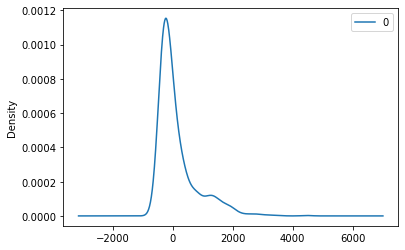

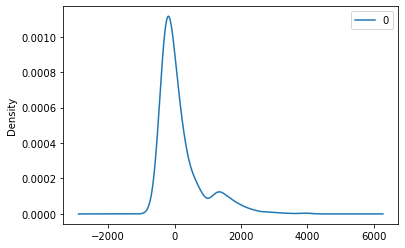

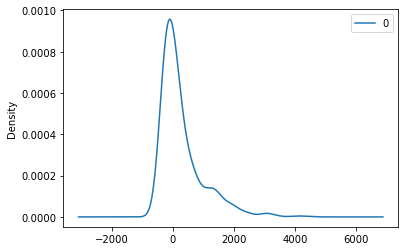

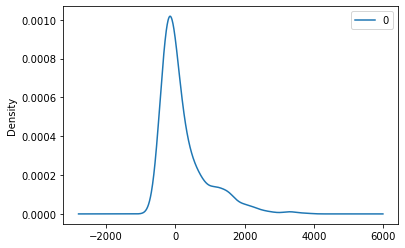

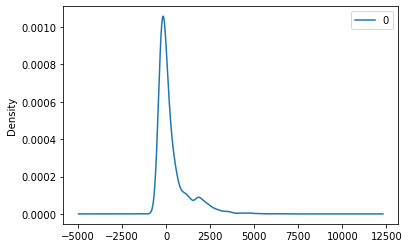

In [19]:
vecRev = vecRevBinarySearch(vecRev,1.2,0.025,1000,0.47)
print("Finaly! "+str(vecRevBinarySearch(vecRev,1.2,0.025,5000,0.47)))